# Exploratory analysis of the data

As a reminder, besides the regular analysis of our data, we asked ourselves some questions we wanted to answer:
- what percentage of the collisions on average result in an injury or a casualty?
- which borough or part of the city is the least safe for pedestrians?
- are there any seasonal fluctuations in collision frequency?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

import geopandas as gpd
from geopandas import GeoDataFrame
import contextily as ctx
from shapely.geometry import Point, Polygon

data_path = "data/nyc_clean.csv"
boroughs_boundaries_path = "geo_data/borough_boundaries/geo_export_9b71d088-28eb-4953-a49e-90d448bc8b4b.shp"
zip_boundaries_path = "geo_data/zip_boundaries/ZIP_CODE_040114.shp"

In [2]:
nyc_data = pd.read_csv(data_path)
pd.options.display.max_columns = 30 #to see all the columns
nyc_data.head(5)

,unique_key,date,time,borough,zip,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,motorist_injured,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3963695,08/19/2018,0:40,BROOKLYN,11236.0,"40.622414, -73.896484",BELT PARKWAY,UNSPECIFIED,UNSPECIFIED,0,0,0,0,0,0,0,0,SUV/STATION WAGON,SUV/STATION WAGON,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
1,3859433,03/08/2018,13:00,QUEENS,11432.0,"40.720165, -73.79902",168 STREET,GOETHALS AVENUE,UNSPECIFIED,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,PASSENGER VEHICLE,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,UNSPECIFIED,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
2,4028471,11/11/2018,15:40,BRONX,10465.0,"40.827282, -73.83017",HUNTINGTON AVENUE,LAFAYETTE AVENUE,UNSPECIFIED,0,0,0,0,0,0,0,0,SEDAN,SUV/STATION WAGON,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,BACKING UNSAFELY,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
3,4028778,11/16/2018,22:00,BROOKLYN,11237.0,"40.699936, -73.91181",WYCKOFF AVENUE,UNSPECIFIED,UNSPECIFIED,0,0,0,0,0,0,0,0,DUMP,SEDAN,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
4,3821653,01/03/2018,13:05,BRONX,10458.0,"40.85569, -73.881035",UNSPECIFIED,UNSPECIFIED,2475 SOUTHERN BOULEVARD,0,0,0,0,0,0,0,0,PASSENGER VEHICLE,VAN,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,DRIVER INATTENTION/DISTRACTION,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED


## Customising the dataset

First, let's do some housekeeping. We still have some values that need to get taken care of in our dataset. Let's see `zip` and `location` columns.  

In [3]:
nyc_data["zip"].value_counts().head(5) #563 0.0 values

11207.0    754
11101.0    602
0.0        563
11208.0    541
11201.0    532
Name: zip, dtype: int64

In [4]:
nyc_data["location"].value_counts().head(5) #Unspecified 906 values, 0.0 & 0.0 60 values

Unspecified              906
0.0, 0.0                  60
40.608757, -74.038086     55
40.798256, -73.82744      52
40.604153, -74.05198      43
Name: location, dtype: int64

In [5]:
zip_loc_boolmask = ((nyc_data["zip"] != 0.0) & (nyc_data["location"] != "0.0, 0.0") & 
                    (nyc_data["location"] != "Unspecified"))

In [6]:
nyc_data.shape, nyc_data[zip_loc_boolmask].shape

((44073, 27), (42544, 27))

As we can see, we have some placeholder values left. We left them when cleaning the dataset, because someone else might use it with different analysis in mind, some values would be lost for them in that case. Since it's only about 1500 records, we will exclude them from our analysis.

In [7]:
nyc_data = nyc_data[zip_loc_boolmask]

### Creating helper columns

Our analysis would greatly improve, if we included some additional columns in our dataset, namely:
- month,
- day,
- day of the week,
- simplified time of collision or time of day

what is more, we will also add latitude and longitude columns to make map visualisation easier.

Let's add day and month columns to our dataset.

In [8]:
dates = nyc_data["date"].str.split("/", n=2, expand=True)
nyc_data.insert(2, "month", dates[0])
nyc_data.insert(3, "day", dates[1])

Let's add weekday column to our dataset to see on what day accidents happen most often.

In [9]:
nyc_data.insert(4, "weekday", [pd.Timestamp(day).day_name() for day in nyc_data["date"]])
nyc_data["weekday"] = nyc_data["weekday"].str.upper()

In both cases we used insert to have our new columns next to original date column. When inserting `weekday` column, to make it faster, we used list comprehension (even though we sacrificed some memory), we made all the entires uppercase just for the sake of being consistent.

Now, let's check the values in `time` column to see how we can simplify those values (if at all) and make them easier to analyse.

In [10]:
nyc_data["time"].value_counts(normalize=True).head()

0:00     0.015701
16:00    0.014902
14:00    0.014667
15:00    0.014291
17:00    0.014103
Name: time, dtype: float64

We can see that around 40 most common values in `time` column are either 0 minutes past hour or 30 minutes past hour. Based on that, we can make a decision to create another column containing just the hour of collision. We'll also change neccessary column types.

In [11]:
hours = nyc_data["time"].str.split(":", n=1, expand=True)
nyc_data.insert(6, "hour", hours[0])

Finally, let's add latitude and longitude columns.

In [12]:
coordinates = nyc_data["location"].str.split(", ", n=1, expand=True)
nyc_data.insert(10, "latitude", coordinates[0])
nyc_data.insert(11, "longitude", coordinates[1])

In [13]:
nyc_data = nyc_data.astype({"month": int, "day": int,"hour": int, 
                            "zip": int, "latitude": float, "longitude": float})

Let's see how our dataset looks after all the changes. 

In [14]:
nyc_data.head(5)

,unique_key,date,month,day,weekday,time,hour,borough,zip,location,latitude,longitude,on_street,cross_street,off_street,...,total_injured,pedestrians_killed,cyclist_killed,motorist_killed,total_killed,vehicle_type_1,vehicle_type_2,vehicle_type_3,vehicle_type_4,vehicle_type_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3963695,08/19/2018,8,19,SUNDAY,0:40,0,BROOKLYN,11236,"40.622414, -73.896484",40.622414,-73.896484,BELT PARKWAY,UNSPECIFIED,UNSPECIFIED,...,0,0,0,0,0,SUV/STATION WAGON,SUV/STATION WAGON,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
1,3859433,03/08/2018,3,8,THURSDAY,13:00,13,QUEENS,11432,"40.720165, -73.79902",40.720165,-73.799020,168 STREET,GOETHALS AVENUE,UNSPECIFIED,...,0,0,0,0,0,PASSENGER VEHICLE,PASSENGER VEHICLE,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,UNSPECIFIED,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
2,4028471,11/11/2018,11,11,SUNDAY,15:40,15,BRONX,10465,"40.827282, -73.83017",40.827282,-73.830170,HUNTINGTON AVENUE,LAFAYETTE AVENUE,UNSPECIFIED,...,0,0,0,0,0,SEDAN,SUV/STATION WAGON,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,BACKING UNSAFELY,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
3,4028778,11/16/2018,11,16,FRIDAY,22:00,22,BROOKLYN,11237,"40.699936, -73.91181",40.699936,-73.911810,WYCKOFF AVENUE,UNSPECIFIED,UNSPECIFIED,...,0,0,0,0,0,DUMP,SEDAN,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,UNSPECIFIED,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED
4,3821653,01/03/2018,1,3,WEDNESDAY,13:05,13,BRONX,10458,"40.85569, -73.881035",40.855690,-73.881035,UNSPECIFIED,UNSPECIFIED,2475 SOUTHERN BOULEVARD,...,0,0,0,0,0,PASSENGER VEHICLE,VAN,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED,DRIVER INATTENTION/DISTRACTION,DRIVER INATTENTION/DISTRACTION,NOT INVOLVED,NOT INVOLVED,NOT INVOLVED


## Plotting the map of all collisions

Let's read in our downloaded bounardies file and create a GeoPandas DataFrame. To do that, we will have to choose a [map projection method](http://geopandas.org/projections.html) and zip our longitudes and latitudes to make a Point object using shapely.

In [15]:
boroughs = gpd.read_file(boroughs_boundaries_path)

In [16]:
coordinate_sys = {'init':'espc:4326'}
geometry = [Point(xy) for xy in zip(nyc_data['longitude'], nyc_data['latitude'])]

nyc_geo_df = gpd.GeoDataFrame(nyc_data, crs = coordinate_sys, geometry = geometry)

Let's display the plot.

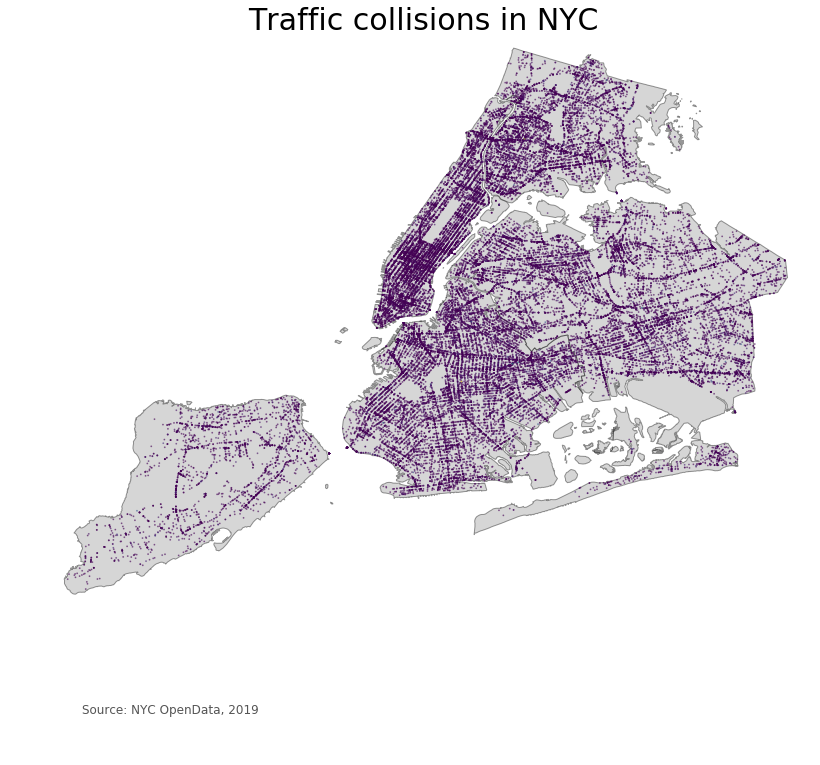

In [17]:
fig, ax = plt.subplots(figsize=(14,14))

boroughs.plot(ax=ax, alpha=0.4, color='0.6', linewidth=1, edgecolor='0')
nyc_geo_df.plot(column='total_injured', ax=ax, alpha=0.5, markersize=0.7)

ax.set_title('Traffic collisions in NYC', size=30)
ax.annotate('Source: NYC OpenData, 2019', xy=(0.1, .08), 
            xycoords='figure fraction', horizontalalignment='left', 
            verticalalignment='top', fontsize=12, color='#555555')

plt.xlim(-74.28,-73.68)
plt.ylim( 40.49, 40.925)
plt.axis('off')
plt.show()

Now that we see all the collisions plotted on the map, our intuition could be to point to Manhattan as the least safe borough and the one, where accidents occur most often. As we will see later, that's not the case. Let's further explore each borough and compare them.  

## Analysing boroughs and zip codes 

In [18]:
nyc_data["borough"].value_counts(normalize=True)*100

BROOKLYN         30.079447
QUEENS           29.129842
MANHATTAN        19.913501
BRONX            15.489846
STATEN ISLAND     5.387364
Name: borough, dtype: float64

As we can see, there are far more accidents that occured in Brooklyn or Queens rather than Manhattan (or any other borough for that matter). Time to check out boroughs in detail - let's take a look at the zip codes.

In [19]:
nyc_data["zip"].value_counts().head()

11207    740
11101    594
11208    527
11201    514
11234    511
Name: zip, dtype: int64

Zip codes by themselfes won't tell us much, so let's create a choropleth map for zip codes to see if there are any  connections between them.

In [20]:
zip_codes = GeoDataFrame.from_file(zip_boundaries_path) 
zip_codes['zip_code'] = zip_codes['ZIPCODE'].astype(int) 

In [21]:
collision_counts = nyc_data['zip'].value_counts()
collision_counts = collision_counts.to_frame(name='count')
collision_counts = collision_counts.reset_index()
collision_counts = GeoDataFrame(collision_counts.merge(zip_codes, how='left', 
                                                       left_on='index', right_on='zip_code'))

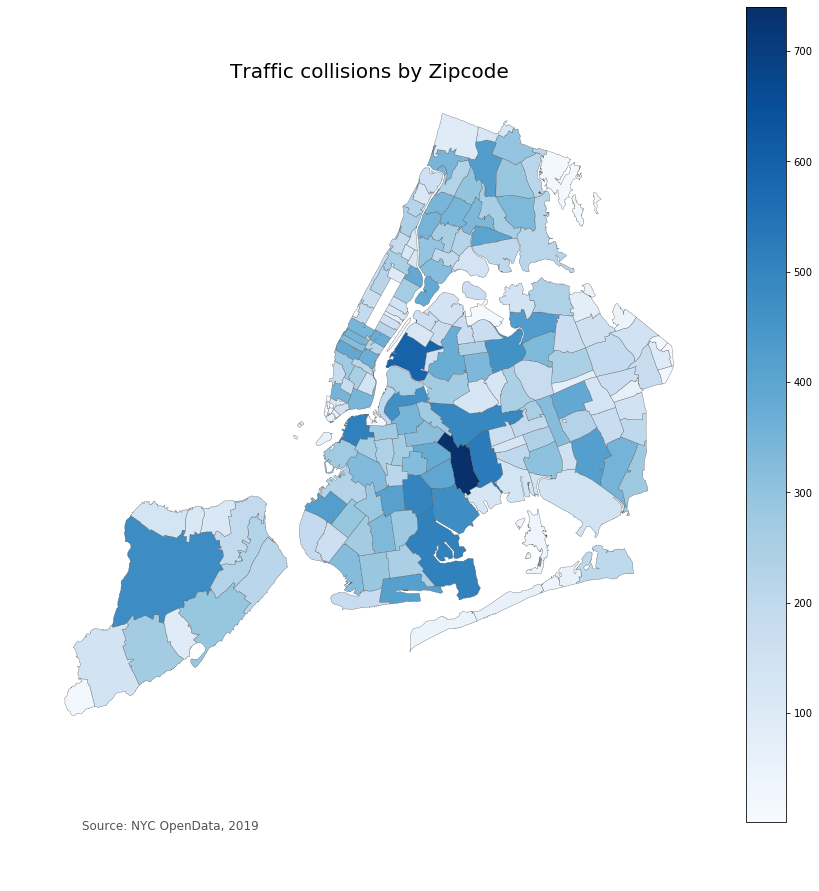

In [22]:
fig, ax = plt.subplots(figsize = (15,15))

collision_counts.plot(column='count', cmap='Blues', alpha=1, linewidth=0.3, ax=ax, edgecolor='0.3', legend=True)

ax.set_title('Traffic collisions by Zipcode', size=20)
ax.annotate('Source: NYC OpenData, 2019', xy=(0.1, .08), 
            xycoords='figure fraction', horizontalalignment='left', 
            verticalalignment='top', fontsize=12, color='#555555')

plt.axis('off')
plt.show()

Clearly, zipcodes that stand out the most are the ones in Brooklyn and Queens, that's where the most collisions happened.

## Analysing dates, times and seasonal fluctuations

In [23]:
nyc_data["date"].value_counts().head(5)

11/15/2018    202
06/29/2018    179
03/02/2018    172
06/21/2018    170
11/09/2018    167
Name: date, dtype: int64

Let's go over some of the days with the highest number of collisions:
- 15th of November, the biggest snowstorm of the year hit the city meaning most of the accidents can be attributed to weather conditions.
- 29th of June
- 2nd of March, [a strong storm hit the city](https://www.nytimes.com/2018/03/02/us/bomb-cyclone-noreaster.html), even causing flights to be grounded in the afternoon. High number of accidents can be easily attributed to weather conditions. 
- 21st of June
- 9th of November

Let's plot all the time data and see if we can find something interesting. Note that the grey line in every plot indicates median for each of the categories. Since we'll do the same later on, let's create a helper method. 

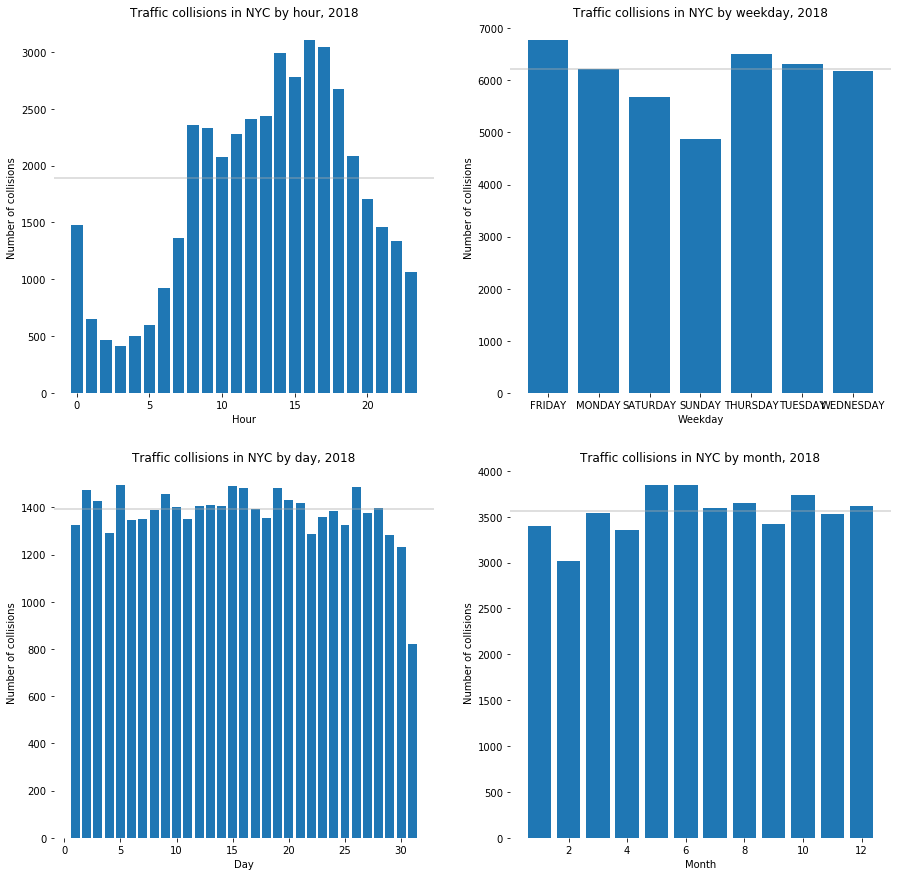

In [24]:
time_cats = ["hour", "weekday", "day", "month"]

def draw_time_graphs(dataset, categories):
    fig = plt.figure(figsize=(15, 15))

    for cat in range(0, 4):
        ax = fig.add_subplot(2,2,cat+1)
        ax.bar(x = dataset[categories[cat]].value_counts().sort_index().index,
               height = dataset[categories[cat]].value_counts().sort_index())
        ax.set_title(f"Traffic collisions in NYC by {categories[cat]}, 2018")
        ax.set_xlabel(categories[cat].title())
        ax.set_ylabel("Number of collisions")
        ax.axhline(dataset[categories[cat]].value_counts().median(),
                   c=(171/255, 171/255, 171/255), alpha=0.5)

        for key,spine in ax.spines.items():
            spine.set_visible(False)

    plt.show()
    
draw_time_graphs(nyc_data, time_cats)    

Let's analyse plots above, one by one:
- Hour: Most accidents happen between 8 and 18, as expected. The number of collisions spikes at 16 and 17.
- Weekday: The number of collisions rises through the week, peaking on Fridays, then decreases rapidly on Saturdays and Sundays, as expected. 
- Day: Nothing seems to indicate any meaningful patterns, except for 31st day of the month, for obvious reasons. 
- Month: Looking at the graph, we can see steady rise of collisions, January through June and then the number stays about the same. May, June and October are months NYC is visited the most by tourists, which might be a factor, but unfortunately, we can't say for sure.

Unfortunately, we weren't able to find anything interesting, as nothing seems to indicate there is anything unusual about the occurence of collisions.

## Analysing streets

Let's analyse streets where collisions occur most frequently. to do it in more efficient manner, let's stack street columns and progress with our analysis.

In [25]:
streets_stacked = nyc_data[["on_street", "cross_street", "off_street"]].stack()

In [26]:
streets_stacked.value_counts().head(10)

UNSPECIFIED                         64062
BELT PARKWAY                          524
BROOKLYN QUEENS EXPRESSWAY            457
GRAND CENTRAL PKWY                    395
BROADWAY                              393
LONG ISLAND EXPRESSWAY                354
ATLANTIC AVENUE                       344
3 AVENUE                              302
CROSS BRONX EXPY                      289
CROSS ISLAND PARKWAY                  285
dtype: int64

It is clear that most collisions by far happen on expressways which might make sense since everyone travels at higher speeds and even minor distractions can cause accidents. One other possible explaination could be "domino effect" happening with one collision leading to another and as we will see later, both cases often resulting in multiple injuries. 

## Analysing injuries and deaths

First, let's check how many injuries and deaths occured. 

In [27]:
not_zero_injuries_boolmask = nyc_data["total_injured"] != 0
not_zero_killed_boolmask = nyc_data["total_killed"] != 0

In [28]:
nyc_data[not_zero_injuries_boolmask].shape, nyc_data[not_zero_killed_boolmask].shape

((8398, 34), (48, 34))

Based on that, we can conclude it's best if we prepare a single analysis for both cases at once, since our findings for collisions resulting in deaths wouldn't be statistically significant on their own anyways.

In [29]:
not_zero_casualties_boolmask = ((not_zero_injuries_boolmask)|(not_zero_killed_boolmask))
casualties_df = nyc_data[not_zero_casualties_boolmask]

(casualties_df.shape[0]/nyc_data.shape[0])*100

19.833584054155697

We can see over 8400 cases where someone has been injured or killed, that means almost 20% of all collisions resulted in an injury or death. 

### Where do casualties occur most often?

In [30]:
casualties_df["borough"].value_counts(normalize=True)*100

BROOKLYN         33.586158
QUEENS           30.161176
BRONX            16.117563
MANHATTAN        15.335388
STATEN ISLAND     4.799716
Name: borough, dtype: float64

Let's check how those values compare to our dataset.

In [31]:
casualties_comparsion = pd.DataFrame({"overall collision pct": nyc_data["borough"].value_counts(normalize=True)*100,
                                      "casualties pct": casualties_df["borough"].value_counts(normalize=True)*100})
casualties_comparsion

,overall collision pct,casualties pct
BRONX,15.489846,16.117563
BROOKLYN,30.079447,33.586158
MANHATTAN,19.913501,15.335388
QUEENS,29.129842,30.161176
STATEN ISLAND,5.387364,4.799716


Based on the above table, the casualties distribution is similiar to overall collision distribution with some notable discrepancies:
- Manhattan accounts for 4.5% less accidents resulting in an injury or death than overall collisions  
- Brooklyn accounts for 3.5% more accidents resulting in an injury or death than overall collisions 

Are there any streets in particular, where injuries or deaths occur most often?  

In [32]:
casualties_df["on_street"].value_counts(normalize=True).head(10)*100

UNSPECIFIED                         15.868689
BELT PARKWAY                         1.374733
BROOKLYN QUEENS EXPRESSWAY           1.208817
GRAND CENTRAL PKWY                   1.007348
LONG ISLAND EXPRESSWAY               0.995497
BROADWAY                             0.983645
MAJOR DEEGAN EXPRESSWAY              0.924390
LINDEN BOULEVARD                     0.900687
ATLANTIC AVENUE                      0.900687
CROSS ISLAND PARKWAY                 0.722920
Name: on_street, dtype: float64

As established earlier, most accidents happen on expressways (in this case with the exception of Broadway) which might make sense since everyone travels at higher speeds and it's easier for accident to cause harm. One other possible explaination could be "domino effect" happening with one collision leading to another, often resulting in multiple injuries or deaths. 

### When do casualties occur most often?

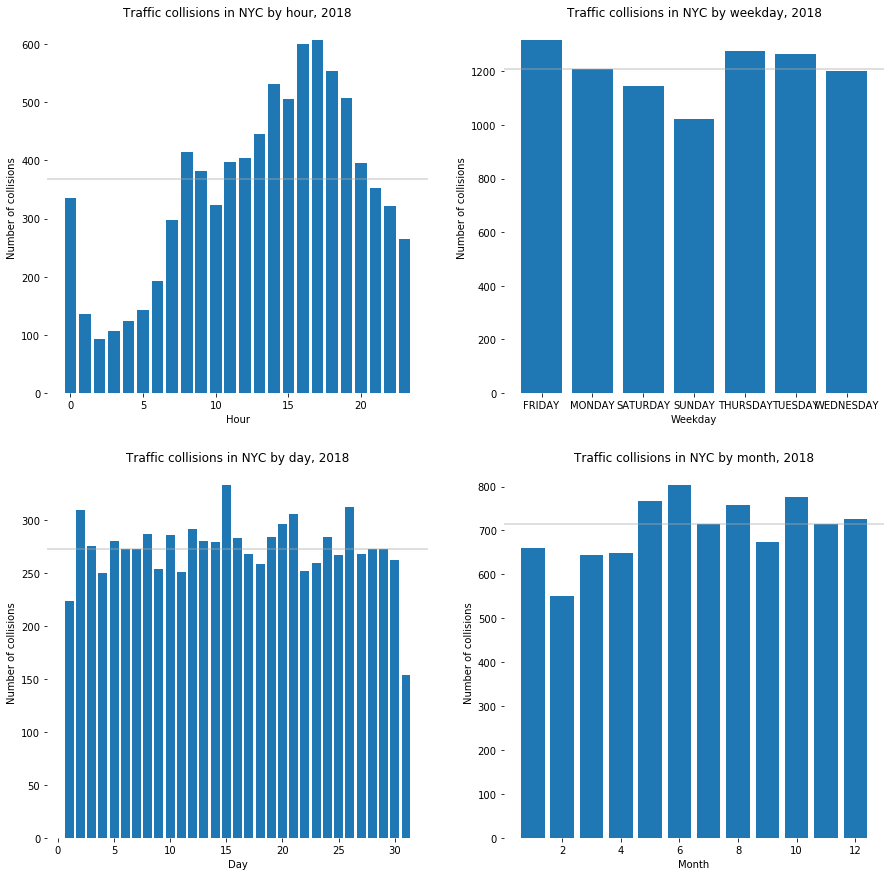

In [33]:
draw_time_graphs(casualties_df, time_cats)

We see no descrepancies between our findings when looking at collisions as a whole versus when looking at collisions only resulting in an injury or death. Let's move on.

## Analysing pedestrian safety

Time to perform similiar analysis just for accidents resulting in pedestrian injury or death 

In [34]:
peds_all_boolmask = ((nyc_data["pedestrians_injured"] !=0) | (nyc_data["pedestrians_killed"] !=0))
peds_killed_boolmask = nyc_data["pedestrians_killed"] !=0
pedestrians_df = nyc_data[peds_all_boolmask]

nyc_data[peds_all_boolmask].shape[0], nyc_data[peds_killed_boolmask].shape[0]

(1985, 27)

In [35]:
peds_participation_pct = (nyc_data[peds_all_boolmask].shape[0] / 
                          nyc_data[not_zero_casualties_boolmask].shape[0])*100
peds_killed_pct = (nyc_data[peds_killed_boolmask].shape[0] / nyc_data[not_zero_killed_boolmask].shape[0])*100

In [36]:
peds_participation_pct, peds_killed_pct

(23.52453187959232, 56.25)

As we can see, pedestrians participate in over 23% of all accidents resulting in injury or death, but they participate in over 56% of all accidents resulting in death!

In [37]:
(pedestrians_df.shape[0]/nyc_data.shape[0])*100

4.6657578036855964

Out of all 44073 collisions, pedestrians are injured or killed in over 4.6% of them.

### Where do pedestrian casualties occur most often? 

In [38]:
pedestrians_df["borough"].value_counts(normalize=True)*100

BROOKLYN         35.717884
QUEENS           25.188917
MANHATTAN        20.251889
BRONX            15.365239
STATEN ISLAND     3.476071
Name: borough, dtype: float64

Let's check how those values compare to our dataset.

In [39]:
casualties_comparsion.insert(2, "ped casualties pct", pedestrians_df["borough"].value_counts(normalize=True)*100)
casualties_comparsion

,overall collision pct,casualties pct,ped casualties pct
BRONX,15.489846,16.117563,15.365239
BROOKLYN,30.079447,33.586158,35.717884
MANHATTAN,19.913501,15.335388,20.251889
QUEENS,29.129842,30.161176,25.188917
STATEN ISLAND,5.387364,4.799716,3.476071


Based on the above table, the pedestrian casualties distribution is similiar to overall collision distribution and casualties distribution with some notable discrepancies:
- Manhattan accounts for about the same number of accidents resulting in an injury or death of a pedestrian than overall collisions, but it's a 5% increase relative to the casualties percentage.  
- Brooklyn accounts for 5.6% more accidents resulting in an injury or death of a pedestrian than overall collisions, which is a further 2.1% increase relative to the casualties percentage.
- Queens accounts for 4% less accidents resulting in an injury or death of a pedestrian than overall collisions 

Are there any streets in particular, where injuries or deaths occur most often?  

In [40]:
pedestrians_df["on_street"].value_counts(normalize=True).head(5)

UNSPECIFIED                         0.202519
BROADWAY                            0.010579
JAMAICA AVENUE                      0.009572
8 AVENUE                            0.007557
2 AVENUE                            0.007053
Name: on_street, dtype: float64

As we can see, there aren't any streets in particular where most accidents involving pedestrian casualties occur, which is good in this case, because it sort of proves our point regarding streets where all the accidents occur.

### When do pedestrian casualties occur most often?

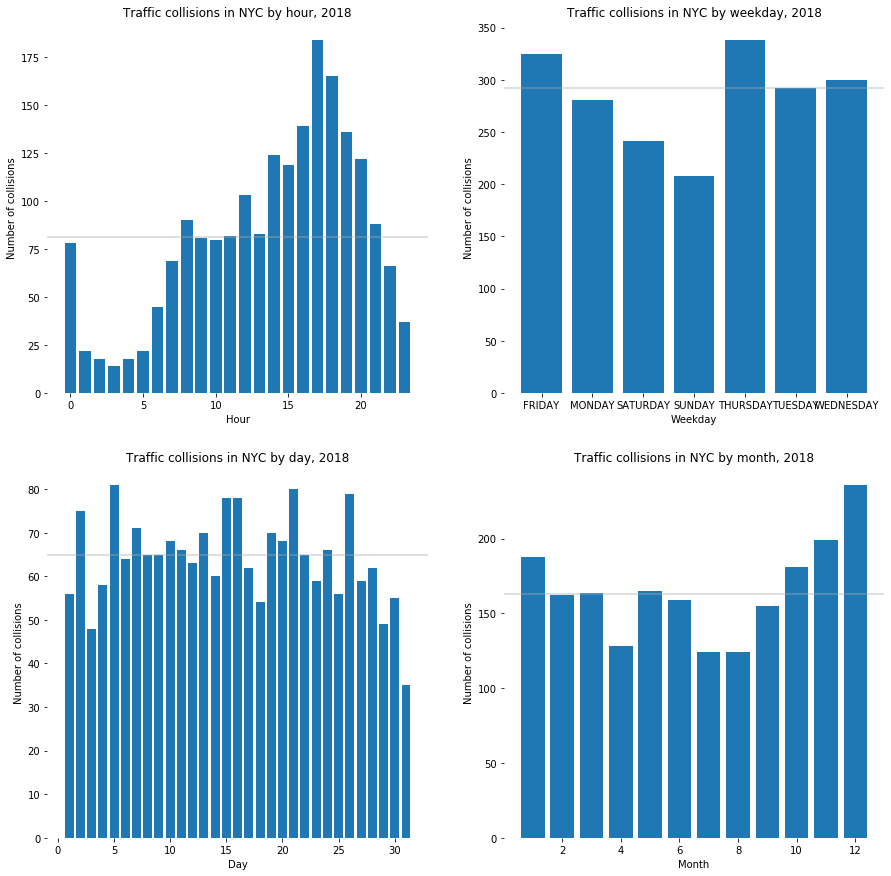

In [41]:
draw_time_graphs(pedestrians_df, time_cats)

As expected, hour, weekday, day of the month don't differ much from our findings from before. However, when looking at pedestrian casualties per month we can see that from October till January far more casualties occur. It could have something to do with weather conditions but we can't say for sure.

## Adding context to collision analysis

In most of our analysis, we could conclude that Brooklyn happened to be the least safe and that's where most accidents happen. In this case, however, it's also important to ask a follow up question: Why?

It would be ideal if we had some way to compare the results to some other metrics. There are 6,300 miles of roads in New York City, however I was unable to find a specific number for all the boroughs. Other relatively reliable metrics to stack up our findings against would be population of each borough and land area of each borough. 

In [42]:
nyc_info = pd.DataFrame(index=casualties_comparsion.index,  
                        data={'population': [1471160, 2648771, 1664727, 2358582 , 479458], 
                              'land_area': [109.04 , 183.42, 59.13 , 281.09, 151.18]})

nyc_info.insert(2, "collisions", nyc_data["borough"].value_counts())
nyc_info.insert(3, "casualties", casualties_df["borough"].value_counts())
nyc_info.insert(4, "ped_casualties", pedestrians_df["borough"].value_counts())

nyc_info

,population,land_area,collisions,casualties,ped_casualties
BRONX,1471160,109.04,6590,1360,305
BROOKLYN,2648771,183.42,12797,2834,709
MANHATTAN,1664727,59.13,8472,1294,402
QUEENS,2358582,281.09,12393,2545,500
STATEN ISLAND,479458,151.18,2292,405,69


The `land_area` column values are in square kilometers. Now let's calculate our metrics and add them to our helper dataset. For the sake of better readibility, we'll present the population columns as per 1000.

In [43]:
nyc_info.insert(3, "collisions_pop", (nyc_data["borough"].value_counts()/nyc_info["population"])*1000)
nyc_info.insert(4, "collisions_area", nyc_data["borough"].value_counts()/nyc_info["land_area"])
nyc_info.insert(6, "casualties_pop", (casualties_df["borough"].value_counts()/nyc_info["population"])*1000)
nyc_info.insert(7, "casualties_area", casualties_df["borough"].value_counts()/nyc_info["land_area"])
nyc_info.insert(9, "ped_casualties_pop", (pedestrians_df["borough"].value_counts()/nyc_info["population"])*1000)
nyc_info.insert(10, "ped_casualties_area", pedestrians_df["borough"].value_counts()/nyc_info["land_area"])

nyc_info

,population,land_area,collisions,collisions_pop,collisions_area,casualties,casualties_pop,casualties_area,ped_casualties,ped_casualties_pop,ped_casualties_area
BRONX,1471160,109.04,6590,4.479458,60.436537,1360,0.924441,12.472487,305,0.207319,2.797139
BROOKLYN,2648771,183.42,12797,4.831297,69.768837,2834,1.069930,15.450878,709,0.267671,3.865445
MANHATTAN,1664727,59.13,8472,5.089123,143.277524,1294,0.777305,21.883984,402,0.241481,6.798579
QUEENS,2358582,281.09,12393,5.254428,44.089082,2545,1.079038,9.054040,500,0.211992,1.778790
STATEN ISLAND,479458,151.18,2292,4.780398,15.160736,405,0.844704,2.678926,69,0.143913,0.456410


Let's analyse metrics regarding population of each borough.

In [44]:
nyc_info.iloc[:, [0,3,6,9]]

,population,collisions_pop,casualties_pop,ped_casualties_pop
BRONX,1471160,4.479458,0.924441,0.207319
BROOKLYN,2648771,4.831297,1.069930,0.267671
MANHATTAN,1664727,5.089123,0.777305,0.241481
QUEENS,2358582,5.254428,1.079038,0.211992
STATEN ISLAND,479458,4.780398,0.844704,0.143913


As we can see, Queens has the highest number of collisions per 1000 people, followed by Manhattan and Brooklyn. When analysing casualties however, it is clear that Queens and Brooklyn have the highest number per 1000, which aligns with our previous analysis. Brooklyn also has the highest number of pedestrian casualties, with Manhattan being a close second. This supports the argument we made earlier, regarding collisions happening more frequently on highways or expressways, because cities with larger area and more roads of said type had highest overall casualties number per 1000, but Manhattan having the least of those roads, has comparable number of pedestrian casualties per 1000.

Now let's analyse metrics regarding land area of each borough.

In [45]:
nyc_info.iloc[:, [1,4,7,10]]

,land_area,collisions_area,casualties_area,ped_casualties_area
BRONX,109.04,60.436537,12.472487,2.797139
BROOKLYN,183.42,69.768837,15.450878,3.865445
MANHATTAN,59.13,143.277524,21.883984,6.798579
QUEENS,281.09,44.089082,9.054040,1.778790
STATEN ISLAND,151.18,15.160736,2.678926,0.456410


Manhattan has clearly the highest number of collisions and casualties per 1 sqared kilometer but that's due to large difference between land area between the boroughs. Having said that, I would argue it's not the least safe:
- it's land area is roughly 3 times smaller than Brooklyn's but every metric is actually not that far off from Brooklyn, meaning the differences are not proportionally as big as the land area might indicate they would,  
- Queen's land area is roughly 4.5 times bigger than Manhattan's but it's metrics aren't that much smaller - same case as with Brooklyn.

Furthermore, I would argue that this metric does not reflect the safety of the district well enough to be considered in our final analysis(because the discrepancies in land area between the boroughs are too big).

## Conclusions

Now it's time to answer some questions we asked ourselves when starting the analysis:
- **What percentage of the collisions on average result in an injury or a casualty?**

Based on the conducted analysis, almost 20% of collisions result in either injury or death. There are no significant descrepancies in where collisions and injuries or deaths happen, however we found out, that 3.5% more injuries/deaths than accidents happen in Brooklyn, and 4.5% less injuries/deaths than accidents happen in Manhattan. What is more, injuries/deaths occur most often in June, typically in the evenings.

- **Which borough or part of the city is the least safe for pedestrians?**

There are a few different ways to answer this question. One way is to look at the sheer amount of collisions resulting in pedestrian casualties or injuries, in which case, Brooklyn and Queens are clearly the most dangerous boroughs. Coincidentally, these are also the biggest by land area and by population. When taking into the account each of the borough's population, Brooklyn and Manhattan appear to be the least safe for pedestrians, with highest number of accidents happening per 1000 people. Which is in part due to the fact that a lot of people work in Manhattan but live elsewhere.

- **Are there any seasonal fluctuations in collision frequency?**

Unfortunately, we weren't able to tell for sure, and data from multiple years is needed to assess that with 100% certainty. When looking at data only for 2018, there are only slight increases in number of accidents in May, June, October and possibly December. These months are regarded as the best time to visit New York City either due to the weather or other tourist attractions, thus the conclusion, that tourist traffic is in part responsible for higher number of traffic collisions.